In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import graphviz


Bad key "ytick.alignment" on line 268 in
/usr/share/matplotlib/mpl-data/stylelib/classic.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution

Bad key "xtick.alignment" on line 250 in
/usr/share/matplotlib/mpl-data/stylelib/classic.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from collections import Counter
from imblearn.datasets import fetch_datasets
from sklearn import svm, tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

In [3]:
df = pickle.load(open('dataframe.pickle', 'rb'))
print(df.dtypes)
df.head()

issuercountrycode                        int64
txvariantcode                           object
bin                                    float64
amount                                 float64
currencycode                            object
shoppercountrycode                      object
shopperinteraction                      object
cardverificationcodesupplied            object
cvcresponsecode                          int64
creationdate                    datetime64[ns]
accountcode                             object
mail_id                                  int64
ip_id                                    int64
card_id                                  int64
label                                    int64
creationdate_timestamp                 float64
amount_distance                        float64
total_cards_used                         int64
dtype: object


,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,label,creationdate_timestamp,amount_distance,total_cards_used
0,76,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,True,0,2015-07-01,MexicoAccount,68370,111778,184798,1,1.435785e+09,0.0,1
1,76,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,True,0,2015-07-02,MexicoAccount,101299,78749,151595,1,1.435805e+09,0.0,1
2,76,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,True,0,2015-07-02,MexicoAccount,278604,70594,242142,1,1.435840e+09,0.0,1
3,76,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,True,0,2015-07-03,MexicoAccount,47409,113648,181744,1,1.435903e+09,0.0,1
4,76,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,True,0,2015-07-08,MexicoAccount,205501,83553,97271,1,1.436373e+09,0.0,1


In [4]:
# TODO: to verify, does this dataframe takes into account Refused transactions?
# How many entries in total ?
df.shape[0]

236698

In [5]:
# How many of those are fraudolent and how many are safe ?
s = df.label.value_counts()
print s
print s[1]/float(s[0])

0    236353
1       345
Name: label, dtype: int64
0.00145968107026


In [6]:
# TODO clean and filter only the interesting features, this is just an example:
df_interesting = df[['label','ip_id','issuercountrycode','amount_distance','total_cards_used']]
df_interesting = df_interesting.sample(frac=1).reset_index(drop=True)
df_interesting.head()

,label,ip_id,issuercountrycode,amount_distance,total_cards_used
0,0,429,7,0.00,1
1,0,138558,40,0.00,1
2,0,36039,40,0.00,1
3,0,149033,40,12833.95,20
4,0,279021,40,-405.00,2


In [7]:
# # Convert categorical variable into dummy/indicator variables for learning
# df_encoded = pd.get_dummies(df_interesting)
# df_encoded = df_encoded.sample(frac=1).reset_index(drop=True)

# df_encoded.head()

In [8]:
# # Creating training and test sets
# training_features, test_features, \
# training_target, test_target, = train_test_split(df_encoded.drop(['label'], axis=1),
#                                                df_encoded['label'],
#                                                test_size = .1,
#                                                random_state=12)
X = np.array(df_interesting.drop(['label'], axis=1))
Y = np.array(df_interesting['label'])
print X.shape
print Y.shape

sm = SMOTE(random_state=12)
svc = svm.SVC()
dtc = tree.DecisionTreeRegressor(max_depth=5)
svc_set = []
dtc_set = []
dot_data_set = []
rank = []

kf = KFold(n_splits=10) #Already shuffled
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    X_train, Y_train = sm.fit_sample(X_train, Y_train)

    #print("X train SIZE: " + str(len(X_train)) + " Y train size: " + str(len(Y_train)))
    #print("X test SIZE: " + str(len(X_test)) + " Y test size: " + str(len(Y_test)))
    dtc = dtc.fit(X_train, Y_train)
    #print(len(X_test))
    #print(X_test)
    #print(len(Y_test))
    for i in range(0, len(X_test)):
        rank.append((X_test[i],Y_test[i],dtc.predict(X_test[i].reshape(1, -1))))
    #break
    dtc_set.append(dtc)
    print("DTC SCORE: " + str(dtc.score(X_test, Y_test)))
    
    dot_data = tree.export_graphviz(dtc, out_file=None,
                               feature_names=list(df_interesting.columns.values[1:]),
                               class_names=['benign','fraud'],filled=True, rounded=True,  
                               special_characters=True
                              ) 
    dot_data_set.append(dot_data)
    
#     svc.fit(X_train, Y_train)
#     svc_set.append(svc)
#     print("SVC SCORE: " + str(svc.score(X_test, Y_test)))
    

(236698, 4)
(236698,)
('TRAIN:', array([ 23670,  23671,  23672, ..., 236695, 236696, 236697]), 'TEST:', array([    0,     1,     2, ..., 23667, 23668, 23669]))
DTC SCORE: -63.8660172122
('TRAIN:', array([     0,      1,      2, ..., 236695, 236696, 236697]), 'TEST:', array([23670, 23671, 23672, ..., 47337, 47338, 47339]))
DTC SCORE: -71.6787349031
('TRAIN:', array([     0,      1,      2, ..., 236695, 236696, 236697]), 'TEST:', array([47340, 47341, 47342, ..., 71007, 71008, 71009]))
DTC SCORE: -81.8677480188
('TRAIN:', array([     0,      1,      2, ..., 236695, 236696, 236697]), 'TEST:', array([71010, 71011, 71012, ..., 94677, 94678, 94679]))
DTC SCORE: -60.5010905896
('TRAIN:', array([     0,      1,      2, ..., 236695, 236696, 236697]), 'TEST:', array([ 94680,  94681,  94682, ..., 118347, 118348, 118349]))
DTC SCORE: -76.6915969785
('TRAIN:', array([     0,      1,      2, ..., 236695, 236696, 236697]), 'TEST:', array([118350, 118351, 118352, ..., 142017, 142018, 142019]))
DTC SCOR

In [15]:
df_rank = pd.DataFrame(rank, columns=['feature_vector','label','target'])
df_rank = df_rank.sort_values(by=['target'],ascending=)
df_rank

,feature_vector,label,target
64919,"[317517.0, 97.0, 0.0, 1.0]",0,[0.0]
173957,"[351774.0, 97.0, 0.0, 1.0]",0,[0.0]
89200,"[343083.0, 97.0, 0.0, 1.0]",0,[0.0]
143461,"[147991.0, 40.0, 1367.85714286, 7.0]",0,[0.0]
219000,"[234165.0, 97.0, 22550.0, 2.0]",0,[0.0]
89185,"[295011.0, 97.0, 0.0, 1.0]",0,[0.0]
227384,"[318033.0, 97.0, 0.0, 1.0]",0,[0.0]
109381,"[235794.0, 105.0, 0.0, 1.0]",0,[0.0]
154084,"[351628.0, 97.0, 0.0, 1.0]",0,[0.0]
89141,"[342932.0, 97.0, 0.0, 1.0]",0,[0.0]


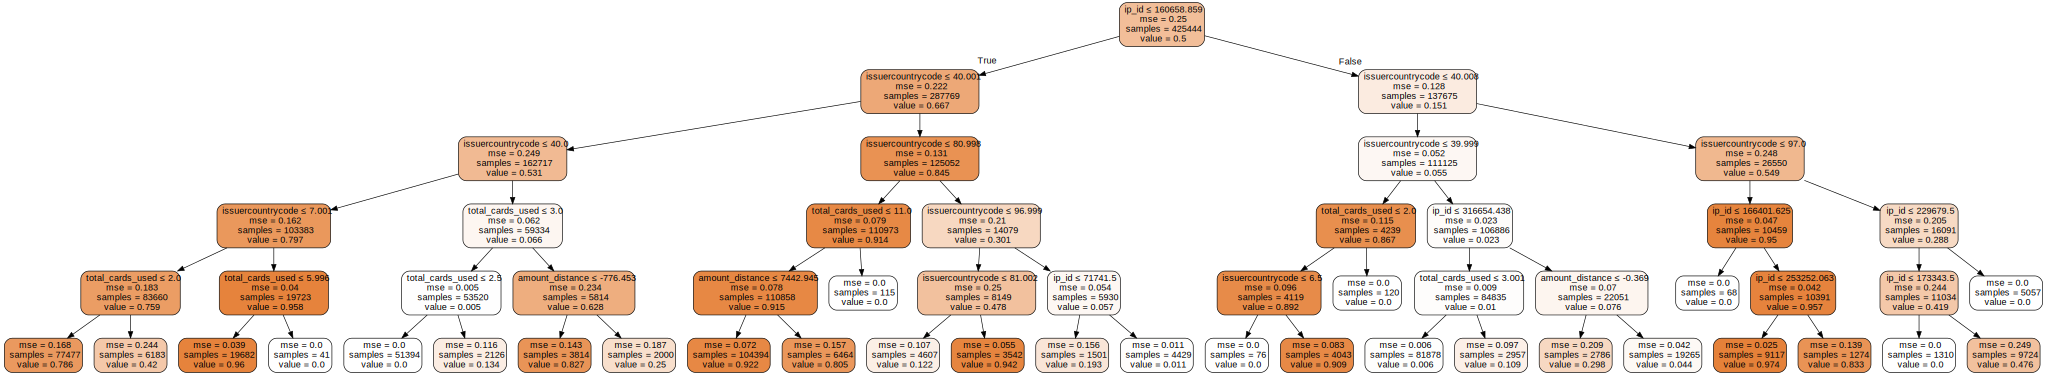

In [9]:
graph = graphviz.Source(dot_data_set[0]) 
graph

In [10]:
# print(training_features.shape)
# print(training_target.shape)

In [11]:
# # SMOTE analysis (note, this is done after sampling)
# sm = SMOTE(random_state=12)
# x_res, y_res = sm.fit_sample(training_features, training_target)
# print training_target.value_counts()
# print np.bincount(y_res)
